In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from nbconvert import PythonExporter
import os
from tqdm import tqdm
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, log_loss
import time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import Xception
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks, regularizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay

2025-09-07 08:16:07.318524: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757232967.710221      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757232967.814429      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from keras.applications.xception import preprocess_input

#### Loading data ####

In [4]:
# adding the images, labels, styles
file_path = "/kaggle/input/data-sampling10000-topstyles10/data_sampling10000_topstyles10.csv"
df = pd.read_csv(file_path)
df.head()

,artist,style,movement,tags,url,img,file_name,genre_list,Artwork,Date
0,Panayiotis Tetsis,Impressionism,Post-Impressionism,NaN,https://www.wikiart.org/en/panayiotis-tetsis/s...,https://uploads3.wikiart.org/images/panayiotis...,127519-sunset.jpg,['cloudscape'],NaN,NaN
1,Henry Scott Tuke,Impressionism,Impressionism,"['Fun', 'Vacation', 'summer']",https://www.wikiart.org/en/henry-scott-tuke/th...,https://uploads5.wikiart.org/00261/images/henr...,100529-henry-scott-tuke-the-bathers-1922.jpg,['genre painting'],NaN,NaN
2,Alfred Sisley,Impressionism,Impressionism,"['fires-and-floods', 'forests-and-trees', 'Ban...",https://www.wikiart.org/en/alfred-sisley/the-f...,https://uploads1.wikiart.org/images/alfred-sis...,92312-the-flood-on-the-road-to-saint-germain-1...,['landscape'],NaN,NaN
3,Camille Pissarro,Impressionism,Impressionism,"['Grassland', 'Meadow', 'Pasture', 'Plain']",https://www.wikiart.org/en/camille-pissarro/ro...,https://uploads2.wikiart.org/images/camille-pi...,90106-rolling-landscape-in-winter-1875.jpg,['landscape'],NaN,NaN
4,Guy Rose,Impressionism,Impressionism,"['seas-and-oceans', 'cliffs-and-rocks', 'Bank'...",https://www.wikiart.org/en/guy-rose/grey-after...,https://uploads3.wikiart.org/images/guy-rose/g...,104411-grey-afternoon.jpg,['landscape'],NaN,NaN


In [5]:
df.shape

(10000, 10)

In [6]:
list_images= df['file_name'].unique().tolist()

#### Loading and resize images ####

In [7]:
def load_and_resize_images(list_images):

    images_list = []

    for filename in list_images:
            img_path = os.path.join("/kaggle/input/wikiart-all-artpieces/wikiart/wikiart", filename)
            img = Image.open(img_path).convert('RGB')

            img_resized = img.resize((224, 224), Image.BICUBIC)

            img_array = np.array(img_resized)

            image_preprocessed = preprocess_input(img_array)
            # convert into an array and add to list
            images_list.append(image_preprocessed)

    # Convertir la liste en tableau NumPy
    images_np = np.stack(images_list)
    return images_np

In [8]:
images_np = load_and_resize_images(list_images)

#### Define X and y ####

In [9]:
X = images_np

In [10]:
y = df['style']

In [11]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (10000, 224, 224, 3)
y shape: (10000,)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

#### Encode labels ####

In [13]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [14]:
### Encoding the labels
y_train_cat = to_categorical(y_train_encoded, 10).astype('float32')
y_test_cat = to_categorical(y_test_encoded, 10).astype('float32')

In [15]:
def set_nontrainable_layers(model):

    # Set the first layers to be untrainable
    model.trainable = False

    return model

In [16]:
def load_model():
    model = Xception(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
    return model


In [17]:
model = load_model()
model = set_nontrainable_layers(model)
model.summary()

I0000 00:00:1757233189.263347      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757233189.264066      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [18]:
def add_last_layers(base_model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),

        # Couche dense plus petite + régularisation L2
        layers.Dense(128, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.4),

        # Couche dense encore plus compacte
        layers.Dense(64, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),

        # Sortie finale
        layers.Dense(10, activation='softmax')
    ])

    return model

In [19]:
model = add_last_layers(model)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,132,658 (80.61 MB)

 Trainable params: 271,178 (1.03 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [20]:
def build_model():
    # $CHALLENGIFY_BEGIN
    model = load_model()
    model = add_last_layers(model)

    lr_schedule = ExponentialDecay(
        initial_learning_rate=1e-3,  # ou 1e-4 si tu défiges le backbone
        decay_steps=1314,            # ≈ 3 epochs avec 438 steps/epoch
        decay_rate=0.96,
        staircase=True               # marche par paliers (stable et lisible)
    )
    
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [21]:
model = build_model()

#### Model checkpoint ####

In [22]:
### CHANGE THE NAME WITH THE NAME OF THE MODEL YOU TRIED AND NUMBER OF IMAGES
model_checkpoint = callbacks.ModelCheckpoint("/kaggle/working/Xception_callbacks_v2.keras", monitor='val_loss', verbose=0, save_best_only=True)

#### ReduceLROnPlateau ####

In [23]:
#Reduce the learning rate when the model stops improving
#lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0)
#exponential =

#### EarlyStopping ####

In [24]:
es = EarlyStopping(monitor = 'val_loss',
                   patience = 20,
                   verbose = 1,
                   restore_best_weights = True)

history = model.fit(X_train, y_train_cat,
                    validation_split=0.3,
                    epochs=50,
                    batch_size=16,
                    callbacks=[es, model_checkpoint])

Epoch 1/50


I0000 00:00:1757233235.403563      99 service.cc:148] XLA service 0x79d4400051d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757233235.405045      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757233235.405072      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757233238.746411      99 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1757233249.915947      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757233250.071893      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757233250.726293      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

306/307 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.1233 - loss: 2.5350

E0000 00:00:1757233338.088251     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757233338.224625     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


307/307 ━━━━━━━━━━━━━━━━━━━━ 164s 342ms/step - accuracy: 0.1234 - loss: 2.5344 - val_accuracy: 0.1295 - val_loss: 18.6874
Epoch 2/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 96s 313ms/step - accuracy: 0.1796 - loss: 2.2402 - val_accuracy: 0.1976 - val_loss: 3.8908
Epoch 3/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 95s 310ms/step - accuracy: 0.2486 - loss: 2.0887 - val_accuracy: 0.2048 - val_loss: 3.2078
Epoch 4/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 96s 312ms/step - accuracy: 0.2747 - loss: 1.9613 - val_accuracy: 0.2567 - val_loss: 2.1878
Epoch 5/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 94s 306ms/step - accuracy: 0.3066 - loss: 1.8607 - val_accuracy: 0.2595 - val_loss: 2.2956
Epoch 6/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 96s 312ms/step - accuracy: 0.3394 - loss: 1.7944 - val_accuracy: 0.3290 - val_loss: 1.8156
Epoch 7/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 95s 308ms/step - accuracy: 0.3770 - loss: 1.6848 - val_accuracy: 0.2586 - val_loss: 2.6725
Epoch 8/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 94s 306ms/step - accuracy: 0.4183 - loss: 1.5963 - v

In [25]:
model.save("/kaggle/working/model_Xception_firsttrain_v2.keras")

#### Evaluating the model ####

In [26]:
model.evaluate(X_test, y_test_cat, return_dict=True)

94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.3447 - loss: 1.8111


{'accuracy': 0.34033334255218506, 'loss': 1.814432144165039}

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

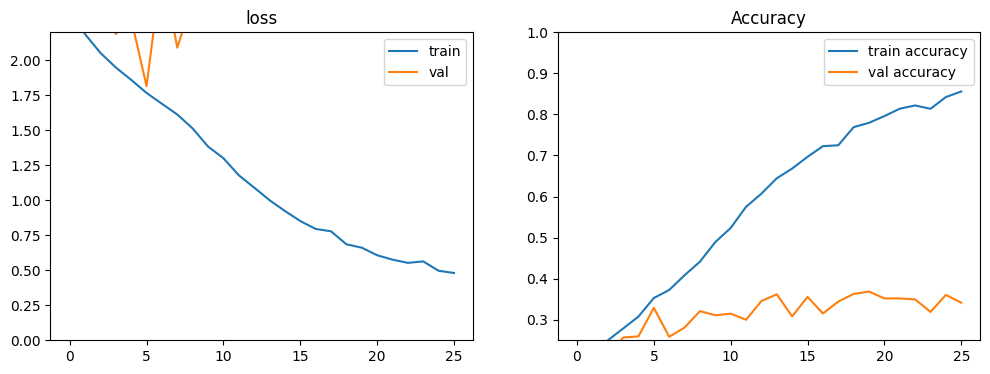

In [27]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()
    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)
plot_history(history)

#### Testing ####

In [28]:
images_paths = ["/kaggle/input/images-to-try/Paul_Czanne_-_The_Basket_of_Apples_-_1926.252_-_Art_Institute_of_Chicago.jpg",
                "/kaggle/input/images-to-try/Piet_Mondriaan_1942_-_New_York_City_I.jpg",
                "/kaggle/input/images-to-try/Two_Young_Girls_at_the_Piano_MET_rl1975.1.201.R.jpg",
                "/kaggle/input/images-to-try/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"]

In [29]:
images_list = []

for img_path in images_paths :
            img = Image.open(img_path).convert('RGB')

            img_resized = img.resize((224, 224), Image.BICUBIC)

            img_array = np.array(img_resized)

            image_preprocessed = preprocess_input(img_array)
            # convert into an array and add to list
            images_list.append(image_preprocessed)

images_np = np.stack(images_list)

In [30]:
X_eval = images_np

In [31]:
X_eval.shape

(4, 224, 224, 3)

In [32]:
preds = model.predict(X_eval)
print(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[2.0416795e-01 3.0672017e-02 1.8459775e-01 9.8765492e-02 6.0671838e-03
  2.3716399e-01 3.4635954e-02 1.3653345e-02 5.8498684e-02 1.3177769e-01]
 [8.4914392e-01 7.0076056e-02 5.0330617e-02 2.1268943e-05 3.2160426e-06
  6.3255602e-03 4.5988759e-06 7.6131789e-07 2.1472633e-02 2.6213280e-03]
 [3.8069562e-04 4.5270548e-04 1.3056511e-02 1.6791031e-03 6.1156994e-01
  1.2536112e-03 7.8820385e-02 1.8852320e-01 8.3765857e-02 2.0498021e-02]
 [1.7695713e-01 4.6485659e-01 1.0371433e-01 1.8098390e-03 9.7783906e-03
  2.3710199e-02 2.2926268e-03 2.0009456e-03 1.8816869e-01 2.6711199e-02]]


In [33]:
# indices
pred_indices = preds.argmax(axis=1)
# label
pred_labels = le.inverse_transform(pred_indices)
pred_labels

array(['Post-Impressionism', 'Abstract Expressionism', 'Neoclassicism',
       'Cubism'], dtype=object)

In [34]:
for img_name, label, pred in zip(images_paths, pred_labels, preds):
    print(f"{img_name} : {label} ({pred.max():.2f})")

/kaggle/input/images-to-try/Paul_Czanne_-_The_Basket_of_Apples_-_1926.252_-_Art_Institute_of_Chicago.jpg : Post-Impressionism (0.24)
/kaggle/input/images-to-try/Piet_Mondriaan_1942_-_New_York_City_I.jpg : Abstract Expressionism (0.85)
/kaggle/input/images-to-try/Two_Young_Girls_at_the_Piano_MET_rl1975.1.201.R.jpg : Neoclassicism (0.61)
/kaggle/input/images-to-try/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg : Cubism (0.46)


### finetuning

In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

In [ ]:
for layer in model.layers[100:132]:  # Excluding the layers we add ourself
    layer.trainable = True


In [ ]:
for i, layer in enumerate(model.layers[0].layers):
    print(i, layer.name, layer.trainable)

In [ ]:
# Recompiler avec un learning rate plus petit
model.compile(optimizer=optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_phase2 = model.fit(X_train, y_train_cat,
                           validation_split=0.3,
                           epochs=10,
                           callbacks=[es])

Epoch 1/10


E0000 00:00:1757235828.528714      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757235828.718381      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757235830.175709      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757235830.316266      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


In [ ]:
model.save("/kaggle/working/model_Xception_finetuning_v2.keras")

In [ ]:
model.evaluate(X_test, y_test_cat, return_dict=True)

In [ ]:
plot_history(history_phase2)

In [ ]:
images_paths = ["/kaggle/input/images-to-try/Paul_Czanne_-_The_Basket_of_Apples_-_1926.252_-_Art_Institute_of_Chicago.jpg",
                "/kaggle/input/images-to-try/Piet_Mondriaan_1942_-_New_York_City_I.jpg",
                "/kaggle/input/images-to-try/Two_Young_Girls_at_the_Piano_MET_rl1975.1.201.R.jpg",
                "/kaggle/input/images-to-try/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"]

In [ ]:
images_list = []

for img_path in images_paths :
            img = Image.open(img_path).convert('RGB')

            img_resized = img.resize((224, 224), Image.BICUBIC)

            img_array = np.array(img_resized)

            image_preprocessed = preprocess_input(img_array)
            # convert into an array and add to list
            images_list.append(image_preprocessed)

images_np = np.stack(images_list)

In [ ]:
X_eval = images_np

In [ ]:
preds = model.predict(X_eval)
print(preds)

In [ ]:
# indices
pred_indices = preds.argmax(axis=1)
# label
pred_labels = le.inverse_transform(pred_indices)
pred_labels

In [ ]:
for img_name, label, pred in zip(images_paths, pred_labels, preds):
    print(f"{img_name} : {label} ({pred.max():.2f})")